In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

In [2]:
import torch

In [3]:
from behavior_model import LVBehaviorModel, FVBehaviorModel
from synthetic_model import LVTrajSynthetic, FVTrajSynthetic

In [4]:
file_path = 'Synthetic_crash_scenarios.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Model

In [6]:
## Network Parameters 
gru_hidden_size = 256 # Size of GRU's hidden layer
mlp_hidden_size = 128 # Size of MLP's hidden layer
acc_min, acc_max, acc_interval = -9.5, 7, 0.25
output_size = int((acc_max - acc_min)/acc_interval) + 1
input_size = 5

model_lv = LVBehaviorModel(input_size, gru_hidden_size, mlp_hidden_size, output_size).to(device)
model_lv.load_state_dict(torch.load('.\\weights\\bc_lv_val_02.pth')) 
model_lv.eval()

LVBehaviorModel(
  (gru): GRU(5, 256, batch_first=True)
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=67, bias=True)
    (3): LogSoftmax(dim=2)
  )
)

In [7]:
## Network Parameters 
acc_min, acc_max, acc_interval = -9.5, 4, 0.25
gru_hidden_size = 256 # Size of GRU's hidden layer
mlp_hidden_size = 128 # Size of MLP's hidden layer
output_size = int((acc_max - acc_min)/acc_interval) + 1
input_size = 5

model_fv = FVBehaviorModel(input_size, gru_hidden_size, mlp_hidden_size, output_size).to(device)
model_fv.load_state_dict(torch.load('.\\weights\\bc_fv_val_02.pth'))
model_fv.eval()

FVBehaviorModel(
  (gru): GRU(5, 256, batch_first=True)
  (mlp): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=55, bias=True)
    (3): LogSoftmax(dim=2)
  )
  (mlp2): Sequential(
    (0): Linear(in_features=97, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
)

# Crash Generation Example

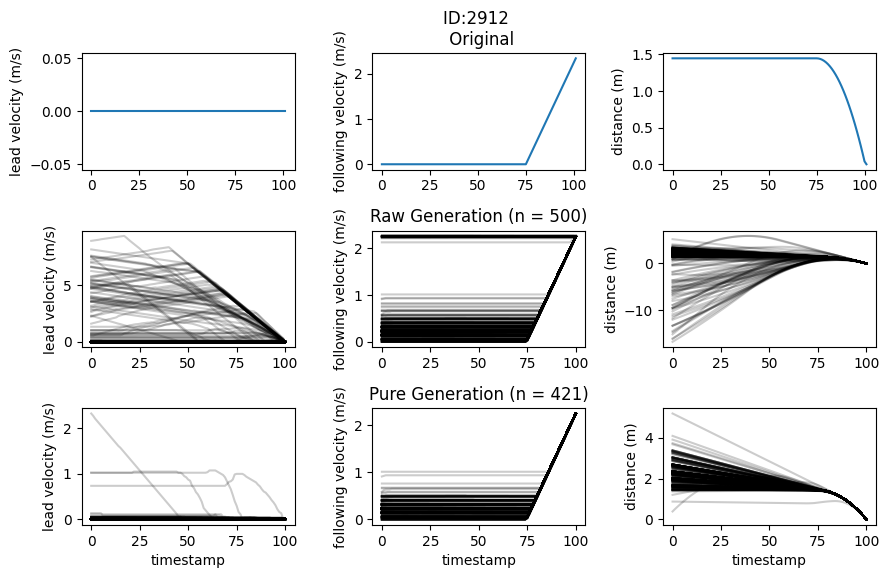

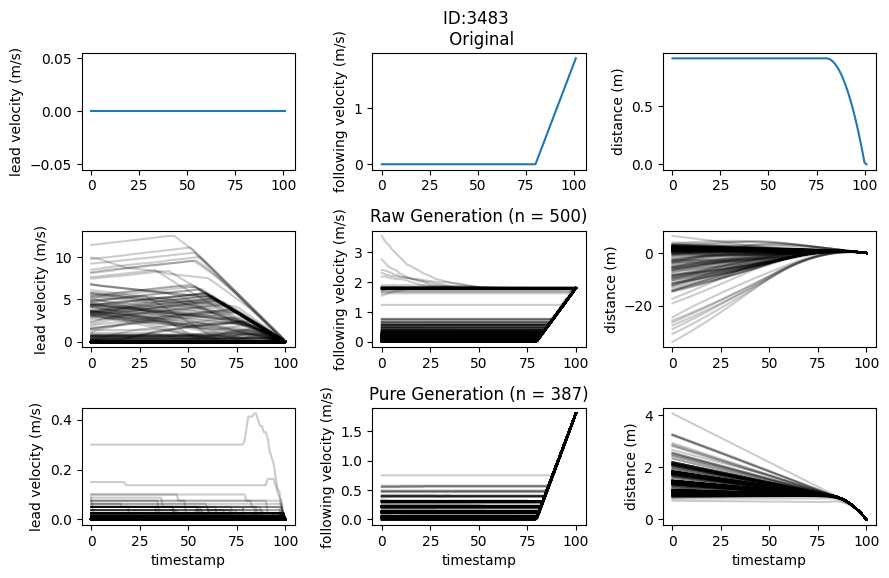

In [8]:
for _ in range(2):
    ID = random.randint(1, 5000)
#     ID = 2530
#     ID = 1421
    v_l_i = df[df["id"]==ID].iloc[:, 3].to_numpy()
    v_f_i = df[df["id"]==ID].iloc[:, 2].to_numpy()
    d_i = df[df["id"]==ID].iloc[:, 4].to_numpy()
    t_i = df[df["id"]==ID].iloc[:, 1].to_numpy()

    #### Gen LV first
    n = 500 # number of trajectories
    V_inputLV, A_inputLV = np.zeros(n), np.zeros(n)
    V_f0_inputLV, A_f0_inputLV = np.zeros(n), np.zeros(n)

    a_0 = (v_l_i[-2]-v_l_i[-3])/0.05
    # V_inputLV = V_inputLV+v_l_i[-1]
    V_inputLV = V_inputLV+v_l_i[-2]
    A_inputLV = A_inputLV+a_0
    V_f0_inputLV = V_f0_inputLV+v_f_i[-2]
    A_f0_inputLV = A_f0_inputLV+(v_f_i[-2]-v_f_i[-3])/0.05

    KM_l_LV = LVTrajSynthetic(model_lv,V_inputLV,A_inputLV,V_f0_inputLV,A_f0_inputLV,T_traj=5,mode="rs",device=device)
    ## KM_l_LV = np.flip(KM_l_LV,axis=1)

    V_f_inputFV, A_f_inputFV, D_inputFV = np.zeros(n), np.zeros(n), np.zeros(n)
    V_l_inputFV = np.zeros((n,KM_l_LV.shape[1]))

    a_f_0 = (v_f_i[-2]-v_f_i[-3])/0.05
    # V_f_inputFV = V_f_inputFV+v_f_i[-1]
    V_f_inputFV = V_f_inputFV+v_f_i[-2]
    A_f_inputFV = A_f_inputFV+a_f_0
    # D_inputFV = D_inputFV+d_i[-1]
    V_l_inputFV = copy.deepcopy(KM_l_LV[:,:,1])

    KM_l_FV, KM_f_FV = FVTrajSynthetic(model_fv,V_f_inputFV,A_f_inputFV,D_inputFV,V_l_inputFV,mode="rs",device=device)
#     KM_l_FV, KM_f_FV = TrajGen_FV_GRU2B(model_fv,V_f_inputFV,A_f_inputFV,D_inputFV,V_l_inputFV,mode="rs",device=device)
    KM_l, KM_f = np.flip(KM_l_FV,axis=1), np.flip(KM_f_FV,axis=1)
    
    V_l = copy.deepcopy(KM_l[:,:,1])
    V_f = copy.deepcopy(KM_f[:,:,1])
    D = copy.deepcopy(KM_l[:,:,0] - KM_f[:,:,0])
    idx_noprecrash = np.all(D[:,:-1] > 0, axis=1)
    idx_wrongvfacc = np.abs((V_f[:,-1]-V_f[:,-2])/0.05 - A_f_inputFV)<0.75
    idx_wrongvlacc = np.abs((V_l[:,-1]-V_l[:,-2])/0.05 - A_inputLV)<0.75
    idx_filter = np.all([idx_noprecrash,idx_wrongvfacc,idx_wrongvlacc],axis=0)
#     idx_filter = np.all([idx_noprecrash,idx_wrongvfacc],axis=0)
    V_l_filter, V_f_filter, D_filter = V_l[idx_filter], V_f[idx_filter], D[idx_filter]


    plt.figure(figsize=(9, 9))

    plt.subplot(5, 3, 1)
    plt.plot(df[df["id"]==ID].iloc[:, 3].to_numpy())
    plt.ylabel("lead velocity (m/s)")
    plt.subplot(5, 3, 2)
    plt.plot(df[df["id"]==ID].iloc[:, 2].to_numpy())
    plt.ylabel("following velocity (m/s)")
    plt.title(f"ID:{ID} \n Original")
    plt.subplot(5, 3, 3)
    plt.plot(df[df["id"]==ID].iloc[:, 4].to_numpy())
    plt.ylabel("distance (m)")

    plt.subplot(5, 3, 4)
    plt.plot(V_l.T, "k-", alpha=.2)
    plt.ylabel("lead velocity (m/s)")
    plt.subplot(5, 3, 5)
    plt.plot(V_f.T, "k-", alpha=.2)
    plt.title(f"Raw Generation (n = {n})")
    plt.ylabel("following velocity (m/s)")
    plt.subplot(5, 3, 6)
    plt.plot(D.T, "k-", alpha=.2)
    plt.ylabel("distance (m)")

    plt.subplot(5, 3, 7)
    plt.plot(V_l_filter.T, "k-", alpha=.2)
    plt.xlabel("timestamp")
    plt.ylabel("lead velocity (m/s)")
    plt.subplot(5, 3, 8)
    plt.plot(V_f_filter.T, "k-", alpha=.2)
    plt.title(f"Pure Generation (n = {V_f_filter.shape[0]})")
    plt.xlabel("timestamp")
    plt.ylabel("following velocity (m/s)")
    plt.subplot(5, 3, 9)
    plt.plot(D_filter.T, "k-", alpha=.2)
    plt.xlabel("timestamp")
    plt.ylabel("distance (m)") 

    plt.tight_layout()
    plt.show()

# Crash Generation

## initialize input

In [9]:
n = 5000
T_traj = 5
l_traj = int(T_traj/0.05+1)

## Initialize LV model and FV model input
V_inputLV, A_inputLV = np.zeros(n), np.zeros(n)
V_f0_inputLV, A_f0_inputLV = np.zeros(n), np.zeros(n)
V_f_inputFV, A_f_inputFV, D_inputFV = np.zeros(n), np.zeros(n), np.zeros(n)
V_l_inputFV = np.zeros((n,l_traj))

for ID in range(1,5001):
    v_l_i = df[df["id"]==ID].iloc[:, 3].to_numpy()
    v_f_i = df[df["id"]==ID].iloc[:, 2].to_numpy()
    
    ## input for LV model
    V_inputLV[ID-1] = v_l_i[-2]
    A_inputLV[ID-1] = (v_l_i[-2]-v_l_i[-3])/0.05
    V_f0_inputLV[ID-1] = v_f_i[-2]
    A_f0_inputLV[ID-1] = (v_f_i[-2]-v_f_i[-3])/0.05
    
    ## input for FV model
    V_f_inputFV[ID-1] = v_f_i[-2]
    A_f_inputFV[ID-1] = (v_f_i[-2]-v_f_i[-3])/0.05

## Generating

In [10]:
# list_crashes = []

# for _ in range(15):
    
#     #### generate LV first
#     KM_l_LV = LVTrajSynthetic(model_lv,V_inputLV,A_inputLV,V_f0_inputLV,A_f0_inputLV,T_traj=T_traj,mode="rs",device=device)
#     V_l_inputFV = copy.deepcopy(KM_l_LV[:,:,1]) ## Extract the LV trajectory (backward) for FV model input
    
#     #### Generate FV then
#     KM_l_FV, KM_f_FV = FVTrajSynthetic(model_fv,V_f_inputFV,A_f_inputFV,D_inputFV,V_l_inputFV,mode="rs",device=device)
#     KM_l, KM_f = np.flip(KM_l_FV,axis=1), np.flip(KM_f_FV,axis=1) ## make both LV and FV Kinematics Matrix forward
    
#     V_l = copy.deepcopy(KM_l[:,:,1])
#     V_f = copy.deepcopy(KM_f[:,:,1])
#     D = copy.deepcopy(KM_l[:,:,0] - KM_f[:,:,0])
#     idx_filter =  np.all(D[:,:-1] > 0, axis=1)
#     V_l_filter, V_f_filter, D_filter = V_l[idx_filter], V_f[idx_filter], D[idx_filter]
#     print(f"qualified rate = {round(D_filter.shape[0]/5000,3)}") # no pre-crash (before the last crash) rate
    
#     ite = 0
#     while True:
#         ite += 1
#         print(f"iteration:{ite}")
        
#         ## extract the input that generated unqualified case
#         idx_regen = ~idx_filter
#         V_inputLV_regen, A_inputLV_regen = V_inputLV[idx_regen], A_inputLV[idx_regen] 
#         V_f0_inputLV_regen, A_f0_inputLV_regen = V_f0_inputLV[idx_regen], A_f0_inputLV[idx_regen] 
#         V_f_inputFV_regen, A_f_inputFV_regen, D_inputFV_regen = V_f_inputFV[idx_regen], A_f_inputFV[idx_regen], D_inputFV[idx_regen]
        
#         if V_inputLV_regen.shape[0] == 0: ## no unqualified case
#             break
            
#         #### generate LV first
#         KM_l_LV_regen = LVTrajSynthetic(model_lv,V_inputLV_regen,A_inputLV_regen,V_f0_inputLV_regen, A_f0_inputLV_regen,T_traj=T_traj,mode="rs",device=device)
#         V_l_inputFV_regen = copy.deepcopy(KM_l_LV_regen[:,:,1]) ## Extract the LV trajectory (backward) for FV model input
#         #### Generate FV then
#         KM_l_FV_regen, KM_f_FV_regen = FVTrajSynthetic(model_fv,V_f_inputFV_regen,A_f_inputFV_regen,D_inputFV_regen,V_l_inputFV_regen,mode="rs",device=device)
#         KM_l_regen, KM_f_regen = np.flip(KM_l_FV_regen,axis=1), np.flip(KM_f_FV_regen,axis=1) ## make both LV and FV Kinematics Matrix forward
        
#         # V_l_regen = copy.deepcopy(KM_l_regen[:,:,1])
#         # V_f_regen = copy.deepcopy(KM_f_regen[:,:,1])
#         D_regen = copy.deepcopy(KM_l_regen[:,:,0] - KM_f_regen[:,:,0])
#         idx_filter_regen = np.all(D_regen[:,:-1] > 0, axis=1)
#         D_filter_regen = D_regen[idx_filter_regen]
#         print(f"total re-generation number: {D_regen.shape[0]}, no pre-crash number: {D_filter_regen.shape[0]}")
        
#         ## replace the uncrashes events
#         KM_f[idx_regen], KM_l[idx_regen] = KM_f_regen, KM_l_regen
#         V_l = copy.deepcopy(KM_l[:,:,1])
#         V_f = copy.deepcopy(KM_f[:,:,1])
#         D = copy.deepcopy(KM_l[:,:,0] - KM_f[:,:,0])
#         idx_filter = np.all(D[:,:-1] > 0, axis=1) # new qualified index
        
#     Arr_crashes = np.empty((n,l_traj,3))
#     Arr_crashes[:,:,0] = copy.deepcopy(V_l)
#     Arr_crashes[:,:,1] = copy.deepcopy(V_f)
#     Arr_crashes[:,:,2] = copy.deepcopy(D)
    
#     list_crashes.append(Arr_crashes)

## Save as dataframe

In [11]:
# for i in range(len(list_crashes)):
    
#     Arr_crashes = list_crashes[i]
#     length = Arr_crashes.shape[1]
    
#     t_intv = 0.05
#     n_crash = Arr_crashes.shape[0]
#     IDs = np.arange(1,n_crash+1)
#     t = np.arange(0, -5.1, -t_intv)[:length]
#     t = np.flip(t)
#     lead_delta_v_all = df[df["t"]==0].iloc[:, 5].to_numpy()
#     weights = df[df["t"]==0].iloc[:, 6].to_numpy()
    
#     d = {'id': np.repeat(IDs,length),
#          'idx': np.ones(n_crash*length,dtype=int)+i,
#          't': np.tile(t,n_crash),
#          'v_f': Arr_crashes[:,:,1].reshape(1,-1).reshape(-1),
#          'v_l': Arr_crashes[:,:,0].reshape(1,-1).reshape(-1),
#          'd': Arr_crashes[:,:,2].reshape(1,-1).reshape(-1),
#          'lead_delta_v': np.repeat(lead_delta_v_all,length),
#          'weight': np.repeat(weights,length)
#     }
#     if i == 0:
#         df_crashes = pd.DataFrame(data=d)
#     else:
#         df_i = pd.DataFrame(data=d)
#         df_crashes = pd.concat([df_crashes, df_i], axis=0, ignore_index=True)

## Combination

In [12]:
for idx in range(15):
    
    #### generate LV first
    KM_l_LV = LVTrajSynthetic(model_lv,V_inputLV,A_inputLV,V_f0_inputLV,A_f0_inputLV,T_traj=T_traj,mode="rs",device=device)
    V_l_inputFV = copy.deepcopy(KM_l_LV[:,:,1]) ## Extract the LV trajectory (backward) for FV model input
    
    #### Generate FV then
    KM_l_FV, KM_f_FV = FVTrajSynthetic(model_fv,V_f_inputFV,A_f_inputFV,D_inputFV,V_l_inputFV,mode="rs",device=device)
    KM_l, KM_f = np.flip(KM_l_FV,axis=1), np.flip(KM_f_FV,axis=1) ## make both LV and FV Kinematics Matrix forward
    
    V_l = copy.deepcopy(KM_l[:,:,1])
    V_f = copy.deepcopy(KM_f[:,:,1])
    D = copy.deepcopy(KM_l[:,:,0] - KM_f[:,:,0])
    idx_filter =  np.all(D[:,:-1] > 0, axis=1)
    V_l_filter, V_f_filter, D_filter = V_l[idx_filter], V_f[idx_filter], D[idx_filter]
    print(f"qualified rate = {round(D_filter.shape[0]/5000,3)}") # no pre-crash (before the last crash) rate
    
    ite = 0
    while True:
        ite += 1
        print(f"iteration:{ite}")
        
        ## extract the input that generated unqualified case
        idx_regen = ~idx_filter
        V_inputLV_regen, A_inputLV_regen = V_inputLV[idx_regen], A_inputLV[idx_regen] 
        V_f0_inputLV_regen, A_f0_inputLV_regen = V_f0_inputLV[idx_regen], A_f0_inputLV[idx_regen] 
        V_f_inputFV_regen, A_f_inputFV_regen, D_inputFV_regen = V_f_inputFV[idx_regen], A_f_inputFV[idx_regen], D_inputFV[idx_regen]
        
        if V_inputLV_regen.shape[0] == 0: ## no unqualified case
            break
            
        #### generate LV first
        KM_l_LV_regen = LVTrajSynthetic(model_lv,V_inputLV_regen,A_inputLV_regen,V_f0_inputLV_regen, A_f0_inputLV_regen,T_traj=T_traj,mode="rs",device=device)
        V_l_inputFV_regen = copy.deepcopy(KM_l_LV_regen[:,:,1]) ## Extract the LV trajectory (backward) for FV model input
        #### Generate FV then
        KM_l_FV_regen, KM_f_FV_regen = FVTrajSynthetic(model_fv,V_f_inputFV_regen,A_f_inputFV_regen,D_inputFV_regen,V_l_inputFV_regen,mode="rs",device=device)
        KM_l_regen, KM_f_regen = np.flip(KM_l_FV_regen,axis=1), np.flip(KM_f_FV_regen,axis=1) ## make both LV and FV Kinematics Matrix forward
        
        # V_l_regen = copy.deepcopy(KM_l_regen[:,:,1])
        # V_f_regen = copy.deepcopy(KM_f_regen[:,:,1])
        D_regen = copy.deepcopy(KM_l_regen[:,:,0] - KM_f_regen[:,:,0])
        idx_filter_regen = np.all(D_regen[:,:-1] > 0, axis=1)
        D_filter_regen = D_regen[idx_filter_regen]
        print(f"total re-generation number: {D_regen.shape[0]}, no pre-crash number: {D_filter_regen.shape[0]}")
        
        ## replace the uncrashes events
        KM_f[idx_regen], KM_l[idx_regen] = KM_f_regen, KM_l_regen
        V_l = copy.deepcopy(KM_l[:,:,1])
        V_f = copy.deepcopy(KM_f[:,:,1])
        D = copy.deepcopy(KM_l[:,:,0] - KM_f[:,:,0])
        idx_filter = np.all(D[:,:-1] > 0, axis=1) # new qualified index
        
    
    t_intv = 0.05
    IDs = np.arange(1,n+1)
    t = np.arange(0, -5.1, -t_intv)[:l_traj]
    t = np.flip(t)
    
    d = {'id': np.repeat(IDs,l_traj),
         'idx': np.ones(n*l_traj,dtype=int)+idx,
         't': np.tile(t,n),
         'v_f': V_f.reshape(1,-1).reshape(-1),
         'v_l': V_l.reshape(1,-1).reshape(-1),
         'd': D.reshape(1,-1).reshape(-1),
         'lead_delta_v': np.repeat(df[df["t"]==0].iloc[:, 5].to_numpy(),l_traj),
         'weight': np.repeat(df[df["t"]==0].iloc[:, 6].to_numpy(),l_traj)
    }
    
    if idx == 0:
        df_crashes = pd.DataFrame(data=d)
    else:
        df_idx = pd.DataFrame(data=d)
        df_crashes = pd.concat([df_crashes, df_idx], axis=0, ignore_index=True)

qualified rate = 0.924
iteration:1
total re-generation number: 378, no pre-crash number: 262
iteration:2
total re-generation number: 116, no pre-crash number: 66
iteration:3
total re-generation number: 50, no pre-crash number: 28
iteration:4
total re-generation number: 22, no pre-crash number: 5
iteration:5
total re-generation number: 17, no pre-crash number: 6
iteration:6
total re-generation number: 11, no pre-crash number: 0
iteration:7
total re-generation number: 11, no pre-crash number: 3
iteration:8
total re-generation number: 8, no pre-crash number: 2
iteration:9
total re-generation number: 6, no pre-crash number: 1
iteration:10
total re-generation number: 5, no pre-crash number: 1
iteration:11
total re-generation number: 4, no pre-crash number: 0
iteration:12
total re-generation number: 4, no pre-crash number: 2
iteration:13
total re-generation number: 2, no pre-crash number: 0
iteration:14
total re-generation number: 2, no pre-crash number: 1
iteration:15
total re-generation nu

qualified rate = 0.92
iteration:1
total re-generation number: 402, no pre-crash number: 286
iteration:2
total re-generation number: 116, no pre-crash number: 60
iteration:3
total re-generation number: 56, no pre-crash number: 29
iteration:4
total re-generation number: 27, no pre-crash number: 15
iteration:5
total re-generation number: 12, no pre-crash number: 2
iteration:6
total re-generation number: 10, no pre-crash number: 8
iteration:7
total re-generation number: 2, no pre-crash number: 0
iteration:8
total re-generation number: 2, no pre-crash number: 1
iteration:9
total re-generation number: 1, no pre-crash number: 1
iteration:10
qualified rate = 0.91
iteration:1
total re-generation number: 449, no pre-crash number: 333
iteration:2
total re-generation number: 116, no pre-crash number: 68
iteration:3
total re-generation number: 48, no pre-crash number: 21
iteration:4
total re-generation number: 27, no pre-crash number: 9
iteration:5
total re-generation number: 18, no pre-crash numbe

In [13]:
df_crashes

,id,idx,t,v_f,v_l,d,lead_delta_v,weight
0,1,1,-5.00,0.000000,0.0375,0.138000,0.809665,0.012977
1,1,1,-4.95,0.000000,0.0375,0.139875,0.809665,0.012977
2,1,1,-4.90,0.000000,0.0375,0.141750,0.809665,0.012977
3,1,1,-4.85,0.000000,0.0375,0.143625,0.809665,0.012977
4,1,1,-4.80,0.000000,0.0375,0.145500,0.809665,0.012977
...,...,...,...,...,...,...,...,...
7574995,5000,15,-0.20,1.836731,0.6090,0.149296,0.122524,1.429095
7574996,5000,15,-0.15,1.599231,0.6090,0.093847,0.122524,1.429095
7574997,5000,15,-0.10,1.349231,0.6090,0.050586,0.122524,1.429095
7574998,5000,15,-0.05,1.111731,0.6090,0.019512,0.122524,1.429095


In [14]:
df_crashes.to_csv('Synthetic_Crash_02.csv', index=False)

# Clustering filter

In [6]:
df_gen = pd.read_csv('Synthetic_Crash_02.csv')
y = np.load('.\\utils_data\\hc_y.npy')
dist_thresholds = np.load('.\\utils_data\\hc_dist_thres.npy')

In [7]:
## read the ID of train, val, test dataset
import pickle
with open('.\\utils_data\\Idx_02_split.pkl', 'rb') as f:
    list_train_val_test = pickle.load(f)
list_train_val_test = list_train_val_test[0]

ID_train, ID_val, ID_test = list_train_val_test[0], list_train_val_test[1], list_train_val_test[2]
ID_train, ID_val, ID_test = ID_train+1, ID_val+1, ID_test+1

In [10]:
filter_gen_train = np.all(
    [df_gen["id"].isin(ID_train),
     df_gen["idx"]<=1,
     df_gen["t"]>-4.84,
#      df_gen["id"] == 1
    ],
    axis=0
)

In [11]:
df_gen_train = df_gen[filter_gen_train].reset_index(drop=True)
df_gen_train

,id,idx,t,v_f,v_l,d,lead_delta_v,weight
0,8,1,-4.80,3.462304,2.825,7.182495,1.276523,0.018637
1,8,1,-4.75,3.499804,2.800,7.148442,1.276523,0.018637
2,8,1,-4.70,3.549804,2.775,7.110952,1.276523,0.018637
3,8,1,-4.65,3.587304,2.750,7.070025,1.276523,0.018637
4,8,1,-4.60,3.599804,2.725,7.026597,1.276523,0.018637
...,...,...,...,...,...,...,...,...
12605,4913,1,-0.20,4.115970,0.005,0.700631,1.393283,0.552813
12606,4913,1,-0.15,3.865970,0.005,0.501333,1.393283,0.552813
12607,4913,1,-0.10,3.465970,0.005,0.318284,1.393283,0.552813
12608,4913,1,-0.05,3.215970,0.005,0.151486,1.393283,0.552813


First, read v_l, v_f, d, and their corresponding  weight

In [12]:
V_f_gen_train = df_gen_train['v_f'].to_numpy()
V_l_gen_train = df_gen_train['v_l'].to_numpy()
D_gen_train = df_gen_train['d'].to_numpy()
Weight_gen_train = df_gen_train['weight'].to_numpy()

V_f_gen_train = V_f_gen_train.reshape(-1,97)
V_l_gen_train = V_l_gen_train.reshape(-1,97)
D_gen_train = D_gen_train.reshape(-1,97)
Weight_gen_train = Weight_gen_train[::97]

In [13]:
from utils_cluster import genNormalizedX

In [14]:
X_gen_train = genNormalizedX(V_l_gen_train,V_f_gen_train,D_gen_train)

In [15]:
X_gen_train.shape

(7446, 291, 2)

Then, calculate the distance matrix

Use distance matrix to do clustering

In [8]:
dm_rawgen = np.load('.\\utils_data\\hc_dm_50_train123.npy')

In [9]:
labels = np.unique(y)
min_dist = np.zeros((dm_rawgen.shape[0],labels.shape[0]))
for i_label, label in enumerate(labels):
    min_dist[:,i_label] = np.min(dm_rawgen[:,y==label],axis=1)

y_gen = labels[np.argsort(min_dist,axis=1)[:,0]]

In [14]:
# np.save(".\\utils_data\\hc_y_02_test1.npy",y_gen)